In [112]:
# 
# calculate the advection-diffusion equation
# using simpliest first-order numerical method

import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

import scipy
from scipy import interpolate
from scipy.sparse import diags
import scipy.sparse as sp

from tqdm import tqdm 


# constant variables
PI = 3.14159

# time step
Dt = 30 # [s]

# grid resolution
Dx = 200 # [m]
Dy = 20 # [m]

# grid number
Nx = 1081
Ny = 120

i_init = round(Nx/2)
j_init = round(Ny/2)
print('center:',i_init,j_init)

x = []
for i in range(Nx):
    x.append((i-i_init)*Dx)
    
y = []
for j in range(Ny):
    y.append((j-j_init)*Dy)

X, Y = np.meshgrid(x, y)

# define diffusion coefficient
Diff_x  = 5 # 10.0 # 5 # 15 # [m2 s-1]
Diff_y  = 0.1 # 0.15 # 0.1 # 0.2 # [m2 s-1]
U_shear = 0.001 # 0.002 # 0.001 # 0.003 # [s-1]

center: 540 60


In [113]:
print( np.tan(2/180*PI) )

0.034920739971461764


U.shape: (120, 1081)


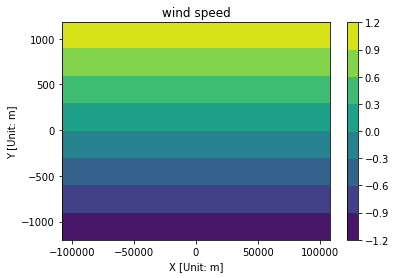

In [114]:
# define a fixed wind field


V = np.zeros([Ny,Nx]) # [m]
U = np.zeros([Ny,Nx])
print('U.shape:',U.shape)

for j in range(Ny):
    U[j,:] = Y[j,:] * U_shear # [m]
    
plt.contourf(X,Y,U)
plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'wind speed' )
plt.show()


In [115]:
# # gaussian analytical results: initial time
# t0 = 3600*3 # [s]

# Sigma0_x = math.sqrt( 2.0*Diff_x*t0*(1+1/12*U_shear**2*t0**2) ) # [m]
# Sigma0_y = math.sqrt( 2.0*Diff_y*t0 ) # [m]

# print(Sigma0_x,Sigma0_y)

# cc = 1000 # [kg m-2]

# C0_gau = np.zeros([Ny,Nx])

# for j in range(Ny):
#     for i in range(Nx):
#         C0_gau[j,i] = cc/(2*PI*Sigma0_x*Sigma0_y)* \
#                         math.exp( -(X[j,i]-0.5*U_shear*t0*Y[j,i])**2/(2*Sigma0_x**2) \
#                                   - Y[j,i]**2/(2*Sigma0_y**2) )
                
# contours = plt.contourf(X, Y, C0_gau, cmap='Reds')
# plt.colorbar()
# plt.xlabel('X [Unit: m]')
# plt.ylabel('Y [Unit: m]')
# plt.title( 'Initial Concentration [kg/m2], time='+str(t0/3600)+' hour' )

# plt.show()

100000000.0


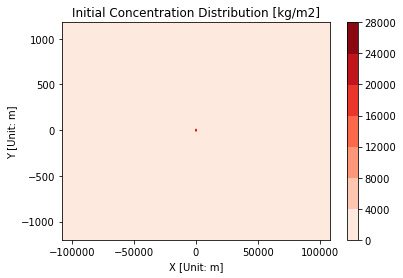

In [116]:
# define initial concentration distribution

C0_gau = np.zeros([Ny,Nx])

Mass = 1.0e+8 # [kg]
C0_gau[j_init,i_init] = Mass/(Dx*Dy) # [kg m-2]
# Concnt[j_init,i_init] = Concnt[j_init,i_init] / 1.0e+6 / 98.0 * AVO

Original = C0_gau[j_init,i_init]*Dx*Dy
print(Original)

contours = plt.contourf(X, Y, C0_gau, cmap='Reds')
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2]' )
plt.colorbar()


plt.show()

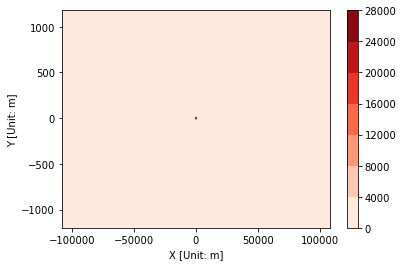

In [117]:
# define initial concentration distribution
Concnt = np.zeros([Ny,Nx])
C_old  = np.zeros([Ny,Nx])

#Concnt[j_init-2:j_init+3,i_init-2:i_init+3] = 1000.0 # [molec m2]
Concnt = C0_gau # [molec m2]

contours = plt.contourf(X, Y, Concnt, cmap='Reds')
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
# plt.title( 'Initial Concentration [kg/m2], time='+str(t0/3600)+' h' )
plt.colorbar()

plt.show()

In [118]:
def Adv_Diff(C, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny):
    C_new = C*0.0
    
    for j in range(1,Ny-1,1):
        for i in range(1,Nx-1,1):
            alpha = Dt*U[j,i]/Dx
            C_new[j,i] = C[j,i] - 0.5*alpha*(C[j,i+1]-C[j,i-1]) \
                            + 0.5*alpha**2*(C[j,i+1]-2*C[j,i]+C[j,i-1]) \
                       + Dt*(Diff_x*(C[j,i-1]+C[j,i+1]-2*C[j,i])/(Dx*Dx) \
                             + Diff_y*(C[j-1,i]+C[j+1,i]-2*C[j,i])/(Dy*Dy) )
    
    return C_new

In [119]:
def Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac):
    
    M2d = Concnt*Dx*Dy
    total_mass = np.sum(M2d, axis=(0,1))
    
    Ysum = np.sum(M2d,axis=1) # sum along x axis
    Ysum_sort = sorted(Ysum, reverse=True)
    Ysum_cum = np.cumsum(Ysum_sort)
    numY = abs(Ysum_cum - frac*total_mass).argmin()
    Yscale = numY*Dy
    
    Xsum = np.sum(M2d,axis=0) # sum along x axis
    Xsum_sort = sorted(Xsum, reverse=True)
    Xsum_cum = np.cumsum(Xsum_sort)
    numX = abs(Xsum_cum - frac*total_mass).argmin()
    Xscale = numX*Dx
    
    return Xscale, Yscale

In [120]:
# Lax–Wendroff Scheme

def Adv_Diff2(C, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny):
    C_new = C*0.0
    C2    = C*0.0

    
    alpha = Dt*U[:,1:i-1]/Dx
    C2[:,1:i-1] = C[:,1:i-1] - 0.5*alpha*(C[:,2:i]-C[:,0:i-2]) \
                          + 0.5*alpha**2*(C[:,2:i]-2*C[:,1:i-1]+C[:,0:i-2])
    
#     for j in range(0,Ny,1):
#         alpha = Dt*U[j,1]/Dx
#         C2[j,1:i-1] = C[j,1:i-1] - 0.5*alpha*(C[j,2:i]-C[j,0:i-2]) \
#                             + 0.5*alpha**2*(C[j,2:i]-2*C[j,1:i-1]+C[j,0:i-2])
     
    
    C_new[1:j-1,1:i-1] = C2[1:j-1,1:i-1] + Dt*(Diff_x*(C2[1:j-1,0:i-2]+C2[1:j-1,2:i]-2*C2[1:j-1,1:i-1])/(Dx*Dx) \
                                             + Diff_y*(C2[0:j-2,1:i-1]+C2[2:j,1:i-1]-2*C2[1:j-1,1:i-1])/(Dy*Dy) )
    
    return C_new

In [121]:
# Test confusion CFL condition
if 2*Diff_y*Dt/(Dy**2)>1:
    print('****************************************')
    print('WARNING: Y: CFL condition is not satisfied')
    print('Try to increase Dy or decrease Dt')
    print('****************************************')
    
if 2*Diff_x*Dt/(Dx**2)>1:
    print('****************************************')
    print('WARNING: X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt')
    print('****************************************')
    
# Test advective CFL condition
if np.max(U)*Dt/Dx>1:
    print('****************************************')
    print('WARNING: X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt')
    print('****************************************')

    contours = plt.contourf(X,Y,Concnt)
#    plt.clabel(contours, inline=True, fontsize=8)
    plt.show()

In [122]:
%%time

# time run
Nt           = int(3600*12/Dt)

# Judge_radian = (90-2)/180*PI # [radians]
scale_ratio  = 25

Theta        = 0.0           # [radians]
Height       = 0.0           #[m]

for t in tqdm(range(Nt)):    
    Concnt = Adv_Diff2(Concnt, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny)
       
    frac = 0.99
    Xscale, Yscale = Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac)
    Theta = math.atan(Xscale/Yscale)
    
    if Xscale/Yscale>scale_ratio:
        print(t*Dt/3600)
        break 

 93%|█████████▎| 1333/1440 [00:08<00:00, 157.53it/s]

11.108333333333333
CPU times: user 8.45 s, sys: 29.7 ms, total: 8.48 s
Wall time: 8.47 s


In [123]:
Xscale, Yscale

(11200, 440)

In [60]:
t0 = (t+1)*Dt  # initial time for 1-D grids
t0/3600

5.183333333333334

In [61]:
np.tan((88)/180*PI)

28.635188185101054

In [62]:
# sensitive test

# time run
Nt = int(3600*24/Dt)
time = t0+Nt*Dt

C1_center = []
C2_center = []
C3_center = []
C4_center = []


Concnt1 = Concnt
Diff2_x = Diff_x # [m2 s-1]
Diff2_y = Diff_y # [m2 s-1]
for t in tqdm(range(Nt)):   
    Concnt1 = Adv_Diff2(Concnt1, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny)
    if Nt*Dt%3600==0:
        C1_center.append(np.max(Concnt1))

        
Concnt2 = Concnt   
Diff2_x = Diff_x # [m2 s-1]
Diff2_y = 0.0 # [m2 s-1]
for t in tqdm(range(Nt)):
    Concnt2 = Adv_Diff2(Concnt2, U, Diff2_x, Diff2_y, Dt, Dx, Dy, Nx, Ny)
    if Nt*Dt%3600==0:
        C2_center.append(np.max(Concnt2))
    
    
Concnt3 = Concnt   
Diff3_x = 0.0 # [m2 s-1]
Diff3_y = Diff_y # [m2 s-1]
for t in tqdm(range(Nt)):
    Concnt3 = Adv_Diff2(Concnt3, U, Diff3_x, Diff3_y, Dt, Dx, Dy, Nx, Ny)
    if Nt*Dt%3600==0:
        C3_center.append(np.max(Concnt3))    
    
    
Concnt4 = Concnt   
Diff4_x = 0.0 # [m2 s-1]
Diff4_y = 0.0 # [m2 s-1]
for t in tqdm(range(Nt)):
    Concnt4 = Adv_Diff2(Concnt4, U, Diff4_x, Diff4_y, Dt, Dx, Dy, Nx, Ny)
    if Nt*Dt%3600==0:
        C4_center.append(np.max(Concnt4))

100%|██████████| 1440/1440 [00:06<00:00, 208.05it/s]


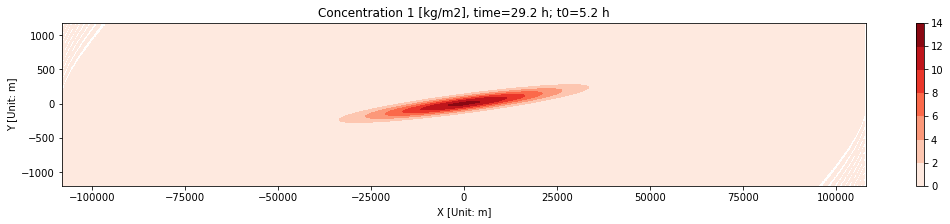

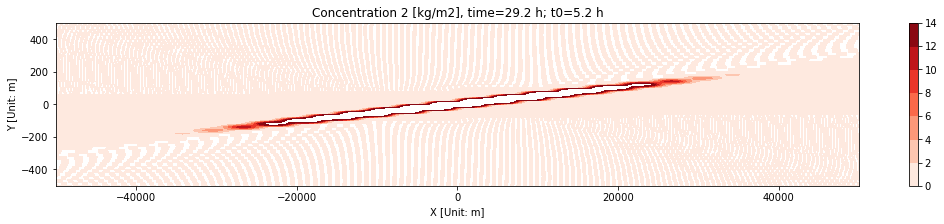

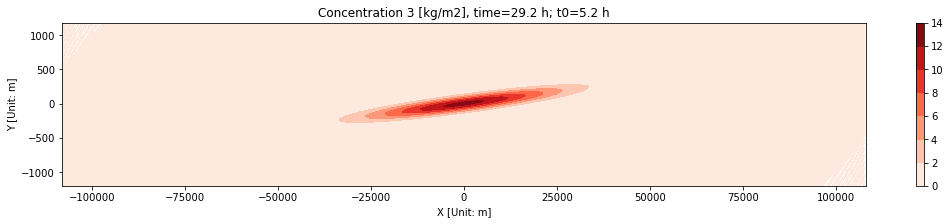

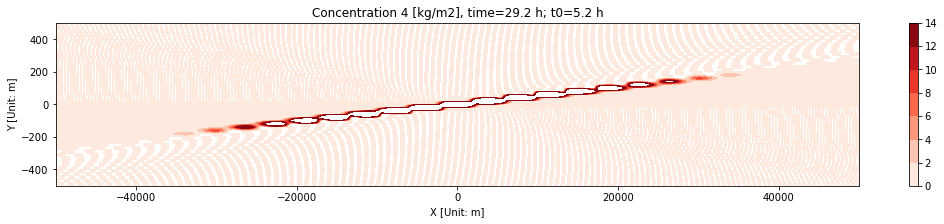

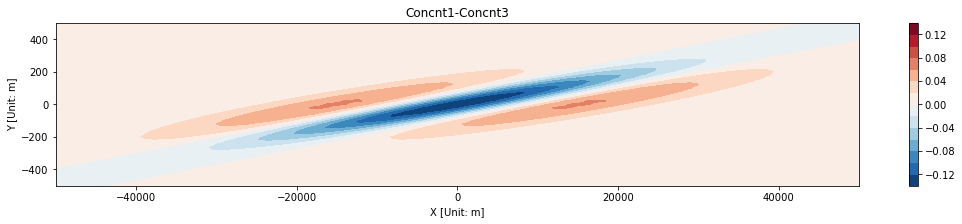

In [63]:
clev = np.arange(0,16,2)

fig, ax = plt.subplots(1, figsize=(18,3))
contours = plt.contourf(X, Y, Concnt1, clev, cmap='Reds')
# plt.xlim(-50000,50000)
# plt.ylim(-500,500)
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( f'Concentration 1 [kg/m2], time={time/3600:0.1f} h; t0={t0/3600:0.1f} h')
plt.colorbar()
plt.show()

fig, ax = plt.subplots(1, figsize=(18,3))
contours = plt.contourf(X, Y, Concnt2, clev, cmap='Reds')
plt.xlim(-50000,50000)
plt.ylim(-500,500)
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( f'Concentration 2 [kg/m2], time={time/3600:0.1f} h; t0={t0/3600:0.1f} h')
plt.colorbar()
plt.show()

fig, ax = plt.subplots(1, figsize=(18,3))
contours = plt.contourf(X, Y, Concnt3, clev, cmap='Reds')
# plt.xlim(-50000,50000)
# plt.ylim(-500,500)
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( f'Concentration 3 [kg/m2], time={time/3600:0.1f} h; t0={t0/3600:0.1f} h')
plt.colorbar()
plt.show()


fig, ax = plt.subplots(1, figsize=(18,3))
contours = plt.contourf(X, Y, Concnt4, clev, cmap='Reds')
plt.xlim(-50000,50000)
plt.ylim(-500,500)
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( f'Concentration 4 [kg/m2], time={time/3600:0.1f} h; t0={t0/3600:0.1f} h')
plt.colorbar()
plt.show()



clev = np.arange(-14e-2,14e-2,2e-2)

fig, ax = plt.subplots(1, figsize=(18,3))
contours = plt.contourf(X, Y, Concnt1 - Concnt3, clev, cmap='RdBu_r')
plt.xlim(-50000,50000)
plt.ylim(-500,500)
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Concnt1-Concnt3')
plt.colorbar()
plt.show()

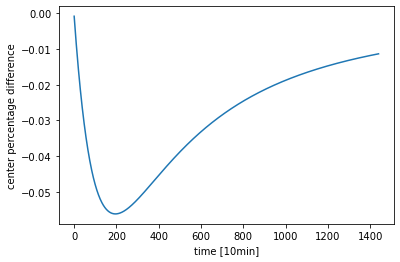

In [64]:
plt.plot( (np.array(C1_center)-C3_center) / np.array(C1_center) );
plt.xlabel('time [10min]');
plt.ylabel('center percentage difference');

In [16]:
# Interpolation along the long_radius direction

ff1 = interpolate.interp2d(x, y, Concnt, kind='linear')
ff2 = interpolate.interp2d(x, y, C2_gau, kind='linear')
f3 = interpolate.interp2d(x, y, C3_gau, kind='linear')
#f4 = interpolate.interp2d(x, y, C4_gau, kind='linear')


N = len(ynew)
print(N)

C1_new = []
C2_new = []
C3_new = []
#C4_new = []


for i in range(N):
    C1_new.append( ff1(xnew[i], ynew[i]) )
    C2_new.append( ff2(xnew[i], ynew[i]) )
    C3_new.append( f3(xnew[i], ynew[i]) )
#    C4_new.append( f4(xnew[i], ynew[i]) )

Concnt1_new = np.array(C1_new)
Concnt2_new = np.array(C2_new)
Concnt3_new = np.array(C3_new)
#Concnt4_new = np.array(C4_new)

print(Concnt1_new.shape)
L = np.sqrt(ynew**2+xnew**2)

plt.plot(L,Concnt1_new,'r',label='Eulerian model')
plt.plot(L,Concnt2_new,'b--',label='Gaussian analyti2')
plt.plot(L,Concnt3_new,'g-.',label='Gaussian analytic3')
#plt.plot(Concnt4_new,'y:',label='Gaussian analytic4')


plt.title( 'time='+str(time)+'s, begin at t0='+str(t0) )
plt.xlabel('Distance Along Long Radius kg/m2]')
plt.legend()

#print(Concnt1_new-Concnt2_new)

# for long-radius direction
#Concnt_gau = xnew*0.0
#for i in range(N):
#    Concnt_gau[i] = cc/(2*PI*Sigma_x*Sigma_y)* \
#        math.exp(-(xnew[i]-X[j_init,i_init]-0.5*U_shear*time*ynew[i])**2 \
#                    /(2*Sigma_x**2) \
#                 -(ynew[i]-Y[j_init,i_init])**2/(2*Sigma_y**2))
#    
#plt.plot(Concnt_gau,'b',label='Gaussian analytic')

NameError: name 'C2_gau' is not defined

In [ ]:
# gaussian analytical result
Sigma_x = math.sqrt( 2/3*U_shear**2*Diff_y*time**3 + U_shear**2*Sigma_y*time**2\
                    + 2.0*Diff_x*time) # [m]
Sigma_y = math.sqrt( 2.0*Diff_y*time ) # [m]
Sigma_xy = math.sqrt( U_shear*Diff_y*time**2 + U_shear*Sigma_y*time )

C4_gau = np.zeros([Ny,Nx])

for j in range(Ny):
    for i in range(Nx):
        C4_gau[j,i] = cc/(2*PI*math.sqrt(Sigma_x**2*Sigma_y**2-Sigma_xy**4) )* \
                        math.exp( -0.5/(Sigma_x**2*Sigma_y**2-Sigma_xy**4)* ( \
                                      Sigma_y**2*(X[j,i]-U_shear*time*Y[j,i])**2.0 \
                                    + Sigma_x**2*Y[j,i]**2 \
                                    - Sigma_xy**2*Y[j,i]*(X[j,i]-U_shear*time*Y[j,i]) \
                                    - Sigma_xy**2*(X[j,i]-U_shear*time*Y[j,i])**2 ) )

        
contours = plt.contourf(X, Y, C4_gau, levs, cmap='Reds')
#contours = plt.contourf(X, Y, C2_gau)
plt.colorbar()
plt.plot(xnew,ynew)
plt.show()